# Enron Scandal Analysis

Before bankruptcy in 2001, Enron was one of the leading companies in the energy sector. It was found that the executives in Enron used accounting loopholes and poor financial reports to hide millions of debt and failed projects. With the scandal going public, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project, I build a person of interest (POI) identifier based on financial and email data made public as a result of the Enron scandal. Using Python and Machine Learning techniques, I select my features of interest, train and fit them on my model and predict results on a testing dataset for predictive analysis.

# 1. Understanding the Dataset

In [160]:
# Initial imports
import sys
import os
import pickle
import re
from time import time
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To show visualizations in iPython
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [161]:
# Loading the data
sys.path.append(".../tools/")
enron_data = pickle.load(open("final_project_dataset.pkl", "r"))

# Converting Python dictionary to Pandas DataFrame (a personal preference)
enron_data = pd.DataFrame.from_dict(enron_data, orient='index', dtype=None)

The dataset contains 146 entries as indexes, and 21 features as columns. Each entery, is an observation for a specific person/employee in the company. The features contain financial information for each observation, as well as, their emails addresses. 

All observations have 1 more feature called `POI`. POI is the abbreviated version of `Person of Interest`. This feature is used to mark whether a specific person in the dataset has been part of the Enron Scandal or not. 

Looking at the first 5 observations in the dataset:

In [162]:
# Preview the first 5 rows in the dataset
enron_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [163]:
# Getting info about type of the data, and number of data points
enron_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


The financial data points in this dataset are makred as `object`/`string`. Since they are financial information, I need to change their type to numeric. 

I also saw quite many `NaN` values in the observations which I need to deal with. For the `NaN` values and the sake of this project, I replace all of those with `0.0`. Doing so will not in any ways harm my analysis.

In [164]:
# Replace the 'NaN' values to Numpy NaN
enron_data.replace(to_replace='NaN', value=np.nan, inplace=True)

# Changing the type of data from object(aka. String) to numeric and filling NaN values with zero
enron_data = enron_data.apply(lambda x: pd.to_numeric(x, errors='ignore')).fillna(0)

Let's see how the dataset looks after the changes:
- The `object` types are all changed to `float64`
- The `NaN` values are set to `0.0`

In [165]:
# Getting info on the type of dataset after applying the changes
enron_data.dtypes

salary                       float64
to_messages                  float64
deferral_payments            float64
total_payments               float64
exercised_stock_options      float64
bonus                        float64
restricted_stock             float64
shared_receipt_with_poi      float64
restricted_stock_deferred    float64
total_stock_value            float64
expenses                     float64
loan_advances                float64
from_messages                float64
other                        float64
from_this_person_to_poi      float64
poi                             bool
director_fees                float64
deferred_income              float64
long_term_incentive          float64
email_address                 object
from_poi_to_this_person      float64
dtype: object

In [166]:
enron_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,0.0,178980.0,182466.0,257817.0,0.0,0.0,0.0,0.0,257817.0,...,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0,0.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,0.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,0.0,0.0,10623258.0,...,0.0,0.0,2660303.0,0.0,False,0.0,-1386055.0,1586055.0,0,0.0
BAY FRANKLIN R,239671.0,0.0,260455.0,827696.0,0.0,400000.0,145796.0,0.0,-82782.0,63014.0,...,0.0,0.0,69.0,0.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,0.0


### How many data points are in the dataset?

There are 146 observations(i.e. people) in the dataset, and each observation has 21 features (i.e. columns) in the dataset.

In [167]:
enron_data.shape

(146, 21)

### For each person, how many features are available? 

Based on the shape of the dataset, for each person there are 21 features available.

### How many POIs are there in the E+F (E-mail + Finance) dataset?

There are 18 POI (Person of Interest) in this dataset.

In [168]:
len(enron_data[enron_data['poi']==1]['poi'])

18

Enron was involved in selling assets to shell companies at the end of each month, and buying them back at the beginning of the next month to hide accounting losses. It was also conspiring to give a Saudi prince expedited American citizenship. 

I would like to also get some info regarding the top executives in Enron during the time the fraud was happening. Information such as:
- Who was the CEO of Enron during most of the time that fraud was being perpetrated?
    - Jeffrey Skilling
- Who was chairman of the Enron board of directors?
    - Kenneth Lay
- Who was CFO (chief financial officer) of Enron during most of the time that fraud was going on?
    - Andrew Fastow

### Of these three individuals (Lay, Skilling and Fastow), who took home the most money? 

Seems like `Kenneth Lay` took home a bit over 100M dollars!

In [169]:
print "Kenneth Lay -> ", enron_data['total_payments']['LAY KENNETH L']
print "Jeffrey Skilling -> ", enron_data['total_payments']['SKILLING JEFFREY K']
print "Andrew Fastow -> ", enron_data['total_payments']['FASTOW ANDREW S']

Kenneth Lay ->  103559793.0
Jeffrey Skilling ->  8682716.0
Andrew Fastow ->  2424083.0


## Finding Outliers in the Dataset

As with any dataset, the data points in this one can contain outliers that can affect the analysis in a wrong way. To find them out, I start by visualising the patterns among some of the features that are interesting to me.

When talking about financial records, salary and bonus can say a lot. I plot these two against each other to see if I find any interesting outliers.

### An Observation I Don't Need

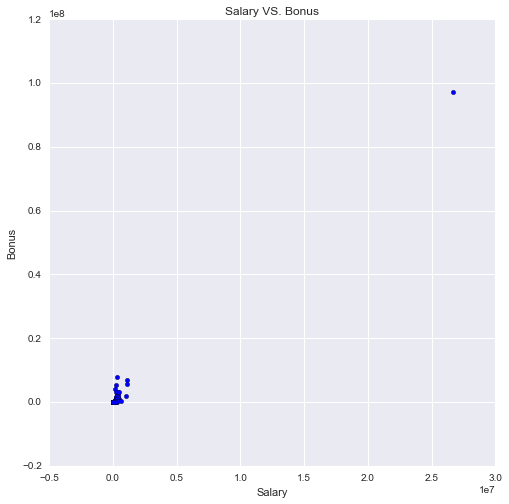

In [170]:
import matplotlib.pyplot as plt
#Plotting salary vs. bonus
fig, ax = plt.subplots(1,1, figsize=(8,8))
plt = plt.scatter(x='salary', y='bonus', data=enron_data)
ax.set_title("Salary VS. Bonus")
ax.set_xlabel("Salary")
ax.set_ylabel("Bonus")
fig.savefig("salary_bonus.png")

Plotting Salary against Bonus, I see an outlier with over 20M in salary and about 10M in bonus. After investigating the dataset, I found out that this data point belong to an observation named `TOTAL`, which obvisouly is not a person in this dataset. Therefore, it needs to be removed.

In [171]:
#Dropping the row named 'TOTAL' as it does not describe any specific person in the dataset
enron_data = enron_data.drop(['TOTAL'])

After removing `TOTAL`, the new plot of Salary vs. Bonus shows a more clear distribution of the data points. There are about 4 more outliers to investigate. Two people made bonuses of at least 5 million dollars, and a salary of over 1 million dollars. I need to check and see if they are data points that need to be removed as well or not.

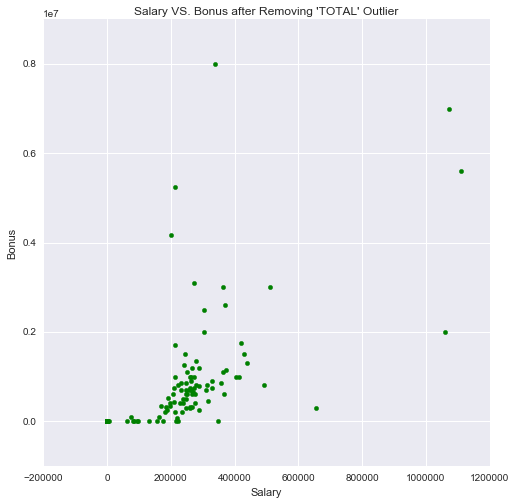

In [172]:
import matplotlib.pyplot as plt
#Plotting salary vs. bonus after removing 'TOTAL' 
fig, ax = plt.subplots(1,1, figsize=(8, 8))
plt = plt.scatter(x='salary', y='bonus', data=enron_data, color='g')
ax.set_title("Salary VS. Bonus after Removing 'TOTAL' Outlier")
ax.set_xlabel("Salary")
ax.set_ylabel("Bonus")
fig.savefig("salary_bonus_no_outlier.png")

In [173]:
print "Those with salaries over 1 million dollors:"
for i in range(len(enron_data['salary'])):
    if enron_data['salary'][i] >= 1000000:
        print enron_data.index.values[i], " | ", enron_data['salary'][i]

print "=============================="

print "Those with bonuses over 5 million dollors:"
for i in range(len(enron_data['bonus'])):
    if enron_data['bonus'][i] >= 5000000:
        print enron_data.index.values[i], " | ", enron_data['bonus'][i]

Those with salaries over 1 million dollors:
FREVERT MARK A  |  1060932.0
LAY KENNETH L  |  1072321.0
SKILLING JEFFREY K  |  1111258.0
Those with bonuses over 5 million dollors:
BELDEN TIMOTHY N  |  5249999.0
LAVORATO JOHN J  |  8000000.0
LAY KENNETH L  |  7000000.0
SKILLING JEFFREY K  |  5600000.0


In [174]:
print "POI's with salaries over 1 million dollors:"
for i in range(len(enron_data['salary'])):
    if enron_data['salary'][i] >= 1000000 and enron_data['poi'][i] == True:
        print enron_data.index.values[i], " | ", enron_data['salary'][i]

print "=============================="

print "POI's with bonuses over 5 million dollors:"
for i in range(len(enron_data['bonus'])):
    if enron_data['bonus'][i] >= 5000000 and enron_data['poi'][i] == True:
        print enron_data.index.values[i], " | ", enron_data['bonus'][i]

POI's with salaries over 1 million dollors:
LAY KENNETH L  |  1072321.0
SKILLING JEFFREY K  |  1111258.0
POI's with bonuses over 5 million dollors:
BELDEN TIMOTHY N  |  5249999.0
LAY KENNETH L  |  7000000.0
SKILLING JEFFREY K  |  5600000.0


Seems the rest of the outliers are actual people in the dataset, more of whom belong to the POI category. Therefore, they are valubale observations for my analysis and I will keep them in the dataset.

### Are There Any Features Not Contributing to POI?

Continuing with cleaning the data, after removing 'TOTAL' as an outlier from the observations, I would like to get some visualisations to see how the features in the dataset contribute to POI. This means I want to find out if any of the features have zero or very few observations which would make them useless for my analysis.

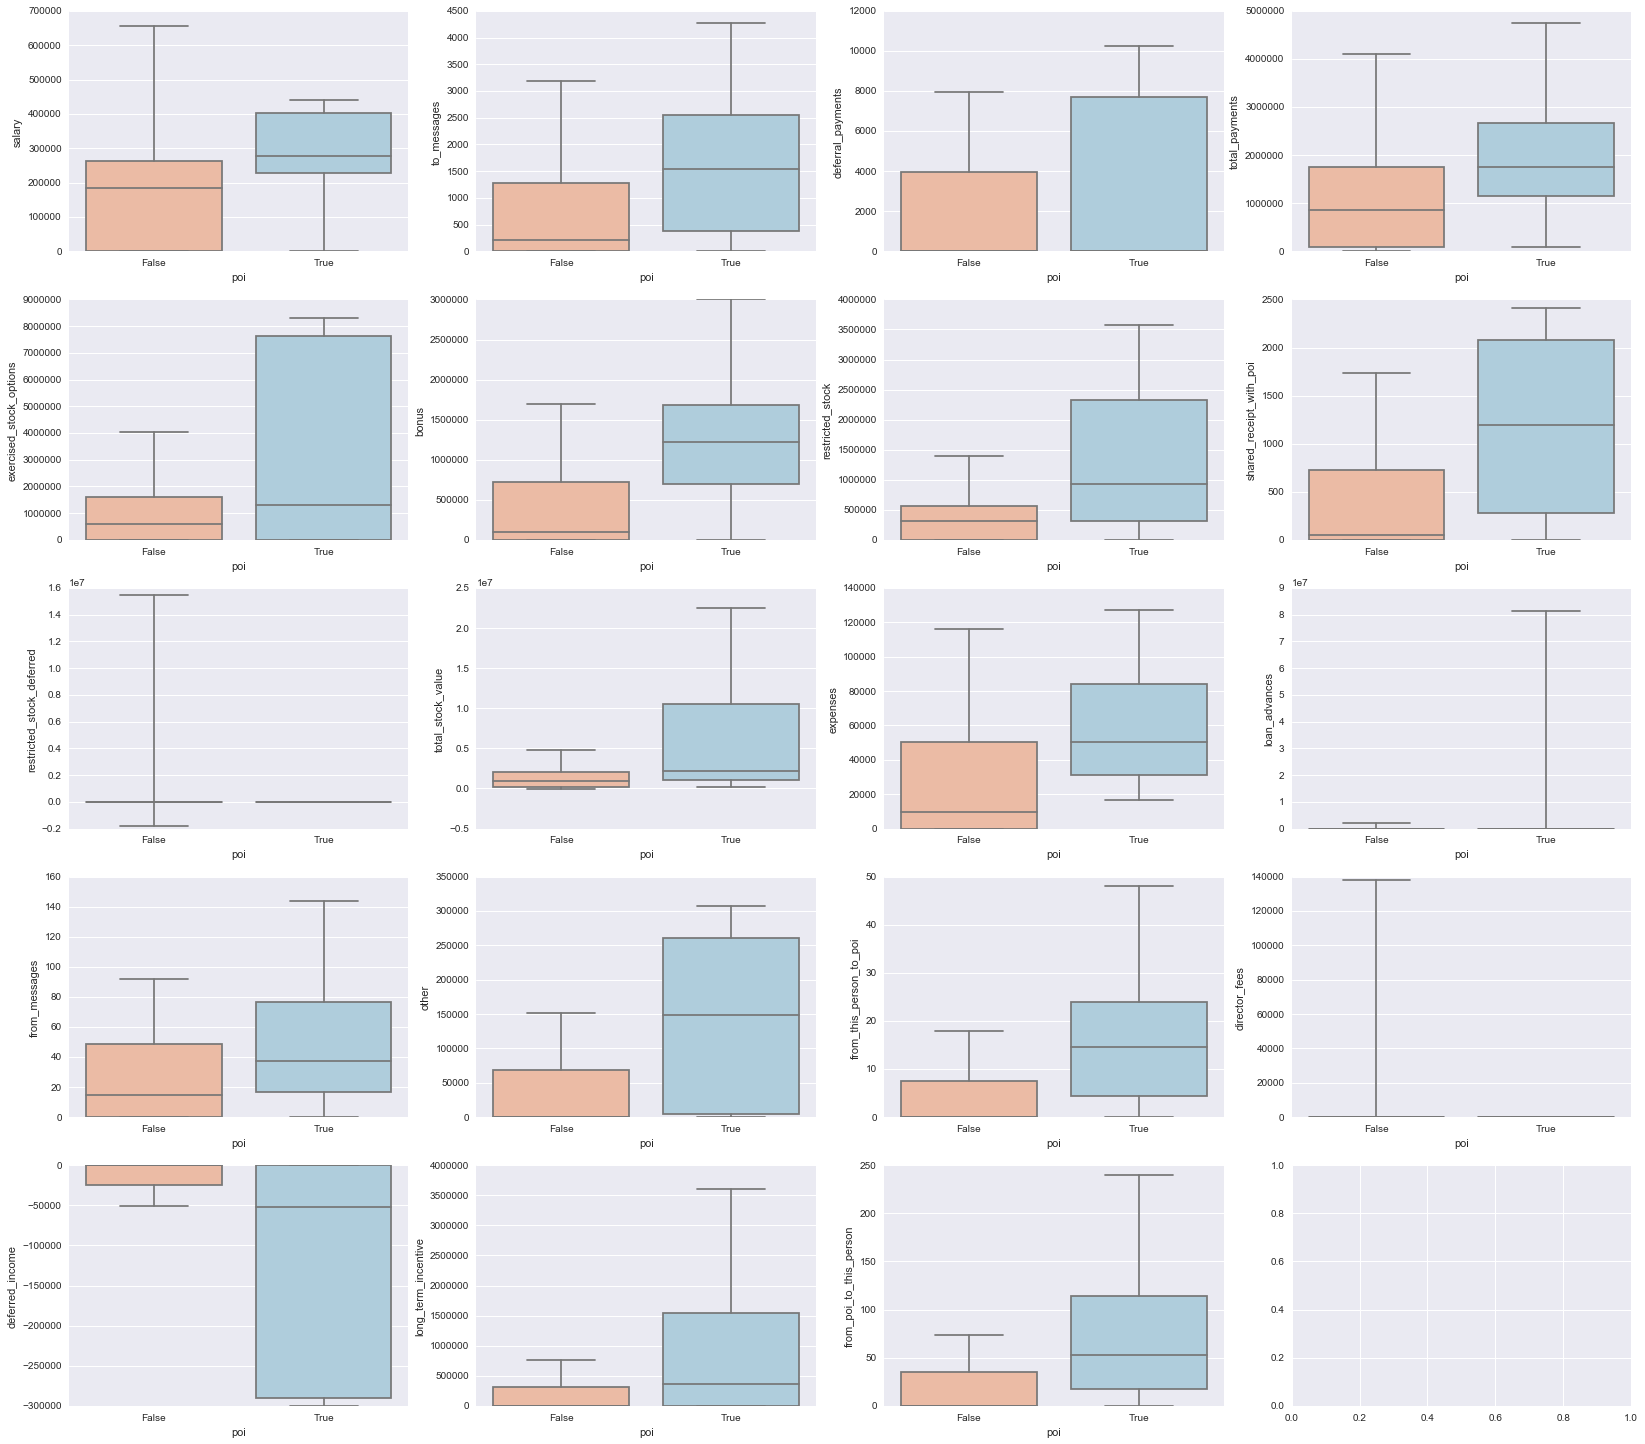

In [175]:
import matplotlib.pyplot as plt

# Defining the dimension of my grid
n_col = 4
n_row = len(list(enron_data.columns.values)) // n_col

# Adding the plots with 'POI' as the x-axis and each other feature as y-axis
i = 0
fig, axs = plt.subplots(n_row, n_col, figsize=(28,25))
for col_name in list(enron_data.columns.values):
    if col_name != 'poi' and col_name != 'email_address':
        sns.boxplot(x="poi", y=col_name, data=enron_data, ax=axs[i // n_col, i % 4], 
                    showfliers=False, palette='RdBu') #removing outliers
        i += 1

These plots show how many observations I have with regards to each feature and the POI. I removed the outliers from all these plots to be able to see the range more clearly. I see that `restricted_stock_deferred`, `loan_advances`, and `director_fees` have no observation with regards to POI. To make sure about this, I perform a simple analysis to see how many observations for each feature are POI. 

In [176]:
def HowManyPOI(df, col_name):
    not_zero = 0
    num_poi = 0
    for i in range(len(df[col_name])):
        if df[col_name][i] != 0.0: #excluding fields that are equal to 0.0
            not_zero += 1
        if df[col_name][i] != 0.0 and df['poi'][i] == True: #fields for which the POI is set to TRUE
            num_poi += 1
    print col_name, " ->", num_poi, "POI out of", not_zero , "in total (non-zero)"

for col_name in list(enron_data.columns.values):
    if col_name == "email_address":
        continue
    HowManyPOI(enron_data, col_name)

salary  -> 17 POI out of 94 in total (non-zero)
to_messages  -> 14 POI out of 86 in total (non-zero)
deferral_payments  -> 5 POI out of 38 in total (non-zero)
total_payments  -> 18 POI out of 124 in total (non-zero)
exercised_stock_options  -> 12 POI out of 101 in total (non-zero)
bonus  -> 16 POI out of 81 in total (non-zero)
restricted_stock  -> 17 POI out of 109 in total (non-zero)
shared_receipt_with_poi  -> 14 POI out of 86 in total (non-zero)
restricted_stock_deferred  -> 0 POI out of 17 in total (non-zero)
total_stock_value  -> 18 POI out of 125 in total (non-zero)
expenses  -> 18 POI out of 94 in total (non-zero)
loan_advances  -> 1 POI out of 3 in total (non-zero)
from_messages  -> 14 POI out of 86 in total (non-zero)
other  -> 18 POI out of 92 in total (non-zero)
from_this_person_to_poi  -> 14 POI out of 66 in total (non-zero)
poi  -> 18 POI out of 18 in total (non-zero)
director_fees  -> 0 POI out of 16 in total (non-zero)
deferred_income  -> 11 POI out of 48 in total (non-z

As seen in the plots, `restricted_stock_deferred` and `director_fees` have zero observation, and `loan_advances` advances has 1 POI out of only 3 observations. Even though `loan_advances` contains some observations, it is not providing any value with regards to predicting a person of interest in the data. I have decided to drop all these three columns from my dataset as well. 

In [177]:
enron_data_2 = enron_data.drop(['restricted_stock_deferred','director_fees','loan_advances'], axis=1)

### Another Observation I Don't Need

Since the number of observations were not that many in this dataset, I took the liberty to take a manual look at the rows as well. I found one row named `THE TRAVEL AGENCY IN THE PARK` in the dataset and has values set to zero. I removed this row from the dataset as well. Further in the analysis I realized that in `feature_format.py` the code removes this observation; therefore, I decided to let the code remove it later in the analysis that to do it myself.

This is how the dataset looks like after removing 1 observation and the 3 unnecessary features:

In [178]:
enron_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 18 columns):
salary                     145 non-null float64
to_messages                145 non-null float64
deferral_payments          145 non-null float64
total_payments             145 non-null float64
exercised_stock_options    145 non-null float64
bonus                      145 non-null float64
restricted_stock           145 non-null float64
shared_receipt_with_poi    145 non-null float64
total_stock_value          145 non-null float64
expenses                   145 non-null float64
from_messages              145 non-null float64
other                      145 non-null float64
from_this_person_to_poi    145 non-null float64
poi                        145 non-null bool
deferred_income            145 non-null float64
long_term_incentive        145 non-null float64
email_address              145 non-null object
from_poi_to_this_person    145 non-null float64
dtypes: bool(1), flo

## More Investigation on the Data before Doing the Analysis 

A few other interesting features for me are those that are related to messages sent to or received by POI. There are features such as `from_poi_to_this_person` and `from_this_person_to_poi` which I plot against each other.

Another feature I would like to visualise is `deferral_payments`. Deferred payments relate to those where the borrower can postpone paying back the load. With regards to `salary`, I would like to see who had the most deffered payments, and if that person was a POI.

### Emails from POIs and to POIs

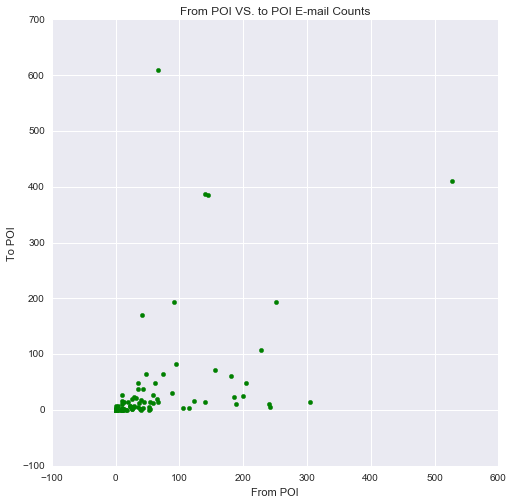

In [179]:
import matplotlib.pyplot as plt

#Plotting from_poi vs. to_poi  
fig, ax = plt.subplots(1,1, figsize=(8, 8))
plt = plt.scatter(x='from_poi_to_this_person', y='from_this_person_to_poi', data=enron_data_2, color='g')
ax.set_title("From POI VS. to POI E-mail Counts")
ax.set_xlabel("From POI")
ax.set_ylabel("To POI")
fig.savefig("from_poi_to_poi_emails.png")


I see a few outliers in the plot:
- 2 with more than 300 emails they received from a person of interest
- 4 few with about 400 or more emails they sent to a person of interest

In [180]:
print "More than 300 E-mails from POI to These People:"
for i in range(len(enron_data_2['from_poi_to_this_person'])):
    if enron_data['from_poi_to_this_person'][i] >= 300:
        print enron_data.index.values[i], " | ", enron_data_2['from_poi_to_this_person'][i]
        
print "==================================================="

print "More than 300 E-mails from Others to POI:"
for i in range(len(enron_data_2['from_this_person_to_poi'])):
    if enron_data['from_this_person_to_poi'][i] >= 300:
        print enron_data.index.values[i], " | ", enron_data_2['from_this_person_to_poi'][i]

More than 300 E-mails from POI to These People:
DIETRICH JANET R  |  305.0
LAVORATO JOHN J  |  528.0
More than 300 E-mails from Others to POI:
BECK SALLY W  |  386.0
DELAINEY DAVID W  |  609.0
KEAN STEVEN J  |  387.0
LAVORATO JOHN J  |  411.0


From the list above, only 'DELAINEY DAVID W' with 609 emails is POI. The rest of the people are not marked as POI in the dataset. One person that gets my attention is 'LAVORATO JOHN J'. He is not a POI but have sent various emails to POI's and received a significant number of emails from them as well. John Lavorato is also one of those who had received an 8 million bonus just before Enron bankruptcy. 

By doing some manual search, I found out that he was indeed one of the top executives in the energy unit of Enron.

### Deferral Paymanets

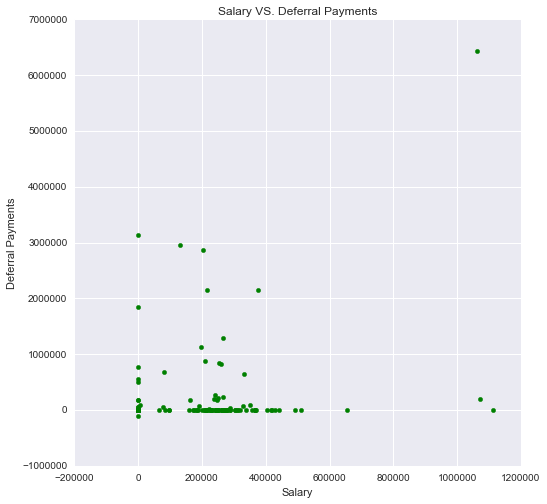

In [181]:
import matplotlib.pyplot as plt

#Plotting from_poi vs. to_poi  
fig, ax = plt.subplots(1,1, figsize=(8, 8))
plt = plt.scatter(x='salary', y='deferral_payments', data=enron_data_2, color='g')
ax.set_title("Salary VS. Deferral Payments")
ax.set_xlabel("Salary")
ax.set_ylabel("Deferral Payments")
fig.savefig("salary_deferral_pay.png")

There is an outlier in this plot that interests me: There is one person with a salary over 1M and deferral payments over 6M dollars. I guess it might be a POI, but I need to find out.

In [182]:
print "More than 5 Million in Deferral Payments:"
for i in range(len(enron_data_2['deferral_payments'])):
    if enron_data_2['deferral_payments'][i] >= 6000000:
        print enron_data_2.index.values[i], " | ", enron_data_2['deferral_payments'][i]


More than 5 Million in Deferral Payments:
FREVERT MARK A  |  6426990.0


Based on the results above, surprisingly the huge 6M deferral payment does not belong to a POI. By doing some research I found out that he used to be one of the CEO's of Enron. He could definately be a person of interest but not marked as so in this dataset.

# 2. Optimize Feature Selection/Engineering

In this section I will select the features I end up using in my POI identifier, and I share the selection process I go through. I explain further about new features I created, how I rescaled them (if applicable). 

Later using the algorithms - in section 3 - I point out if I use any specific feature selection method and provide feature importances for those selections.

In the feature selection step, if I use an algorithm like a decision tree, I will give the feature importances of the features that I use, and if I use an automated feature selection function like SelectKBest, I report the feature scores and reasons for my choice of parameter values. 

## Adding Two New Features

In my dataset, I have two features called `from_this_person_to_poi` and `from_poi_to_this_person`. From the visualisations I did in while exploring the data, I could not find any strong connection between these two features. Therefore, maybe the number of emails sent to or from a person of interest (POI) is not that helpful. One thing I can do is to scale these features by the total number of messages to/from this person.

This means to calculate:
- number of emails from a POI to a given person / total number of emails to that person
- number of emails to a POI from a given person / total number of emails from that person

These two calculations give me the fraction of emails send from/to a given person to/from a POI. This can clarify what portion of an employee's emails were dedicated to/from POIs. If that person is not marked as a POI him/herself, then it might raise the question of whether that person was involved in the fraud or not.

Given a number of messages to/from POI (numerator) and number of all messages to/from a person (denominator),I return the fraction of messages to/from that person that are from/to a POI.

In [183]:
# Adding two new columns to my existing dataframe
enron_data_2['fraction_from_poi'] = ""
enron_data_2['fraction_to_poi'] = ""

# Looping through each row to calculate the fraction for to and from emails
for i in range(len(enron_data_2['to_messages'])):
    if enron_data_2['to_messages'][i] != 0.0:
        v = float(enron_data_2['from_poi_to_this_person'][i]) / float(enron_data_2['to_messages'][i])
        enron_data_2.set_value(enron_data_2.index[i], 'fraction_from_poi', v)
        
    if enron_data_2['to_messages'][i] == 0.0 and enron_data_2['from_poi_to_this_person'][i] == 0.0:
        enron_data_2.set_value(enron_data_2.index[i], 'fraction_from_poi', 0.0)

    if enron_data_2['from_messages'][i] != 0.0:
        v = float(enron_data_2['from_this_person_to_poi'][i]) / float(enron_data_2['from_messages'][i])
        enron_data_2.set_value(enron_data_2.index[i], 'fraction_to_poi', v)
        
    if enron_data_2['from_messages'][i] == 0.0 and enron_data_2['from_this_person_to_poi'][i] == 0.0:
        enron_data_2.set_value(enron_data_2.index[i], 'fraction_to_poi', 0.0)
        

Plotting the two new features to understand the relationship between them better.

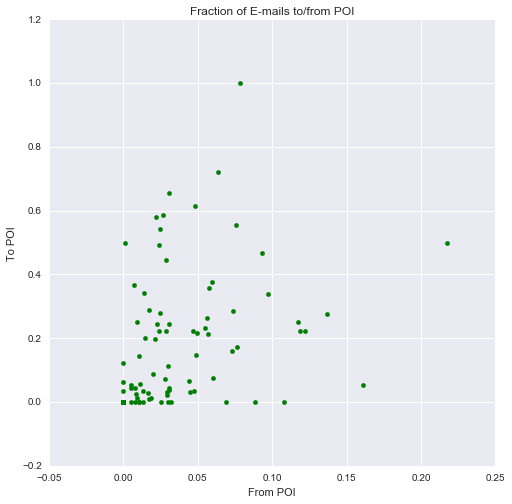

In [184]:
import matplotlib.pyplot as plt

#Plotting from_poi vs. to_poi  
fig, ax = plt.subplots(1,1, figsize=(8, 8))
plt = plt.scatter(x='fraction_from_poi', y='fraction_to_poi', data=enron_data_2, color='g')
ax.set_title("Fraction of E-mails to/from POI")
ax.set_xlabel("From POI")
ax.set_ylabel("To POI")
fig.savefig("emails_to_from_poi.png")

There are a few outliers in this plot. Let's print out the names and see who they are:

In [185]:
print "More than 0.15 of Emails are from POI to This Person:"
for i in range(len(enron_data_2['fraction_from_poi'])):
    if enron_data_2['fraction_from_poi'][i] >= 0.15:
        print enron_data_2.index.values[i], " | ", enron_data_2['fraction_from_poi'][i]

More than 0.15 of Emails are from POI to This Person:
DEFFNER JOSEPH M  |  0.16106442577
DONAHUE JR JEFFREY M  |  0.217341040462


In [186]:
print "More than 0.8 of Emails are from This Person to POI:"
for i in range(len(enron_data_2['fraction_to_poi'])):
    if enron_data_2['fraction_to_poi'][i] >= 0.8:
        print enron_data_2.index.values[i], " | ", enron_data_2['fraction_to_poi'][i]

More than 0.8 of Emails are from This Person to POI:
HUMPHREY GENE E  |  1.0


These are very interesting observations. 
- HUMPHREY GENE E has sent more than 1.0 of his total E-mails to POI, but not that many emails are sent to him from POIs.
- DONAHUE JR JEFFREY M has received about 0.22 of his inbox from a POI
- DEFFNER JOSEPH M has received about 0.16 of his inbox from a POI

After doing the initial loading and cleaning, this is how the dataset looks like. There are currently 144 observations and 20 features (two new columns were added) in the dataset to be used for analysis.

# 3. Pick and Tune an Algorithm

In this section I try a few different classifiers and observe their precision and recall on predicting the POI labels.

From the variety of classifiers, I chose `Naive Bayes`, `Decision Trees`, and `Logistic Regression`. For each algorithm I chose different tuning parameters and feature selection methods too see their performance.

The main feature scaling/selection happens in this part, and I apply them as I start working with each classifier. Based on the scores I receive for precision and recall, I end up choosing the algorithm that can fit my model the best. 

In section 4, I talk more about why I focus on choosing precision, recall and f1-score as my evaluation metrics and why relying only on the accuracy score could not help me in choosing the best algorithm. I also talk about the importance of cross validation which I apply while working with different algorithms.

For the rest of my analysis I convert the Pandas DataFrame to a dictionary to satisfy the project specifications.

In [187]:
# Changing Pandas to dict to work with
enron_data2_dict = enron_data_2.to_dict(orient='index')

# Setting my_dataset to the dictionary to satisfy the project specifications
my_dataset = enron_data2_dict

print "Length of data: ", len(my_dataset)


Length of data:  145


In [231]:
# Necessary SciKit Learn imports
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB
from feature_format import featureFormat, targetFeatureSplit
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from tester import test_classifier, dump_classifier_and_data
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import svm, grid_search, datasets
from sklearn import linear_model, datasets
from sklearn import tree
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

## Features I Select for Analysis

After cleaning the data in section 2 and feature engineering in section 3, I decided to choose the following features in my `features_list`. 

In [190]:
# list of my selected features after cleaning the data from outliers/features I didn't need
features_list = ['poi','salary','to_messages', 'deferral_payments',
                'total_payments','exercised_stock_options','bonus','restricted_stock',
                'shared_receipt_with_poi','total_stock_value','expenses','from_messages',
                'other','from_this_person_to_poi','deferred_income','long_term_incentive',
                'from_poi_to_this_person', 'fraction_from_poi', 'fraction_to_poi']

# Separating the features_list to features and labels for analysis
# POI is the label and every else from features_list[1:] are counted as features
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

## Feature Selection: SelectKBest

Trying a method for feature selection, I am going to use SelectKBest from feature_selection in SciKit Learn. I use this feature selection method with `Naive Bayes` and `Logistic Regression` algorithms.

I ran into a problem while transforming my data, and that was a ValueError complaining about negative values in the dataset for features. To solve this problem, I used **MinMaxScaler()** to scale features between [0,1] and get rid of the negative values this way.

## Feature Scaling: Using MinMaxScaler() before Applying SelectKBest

In [192]:
# Standardization of features using MinMaxScaler() to values between [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
features_minmax = min_max_scaler.fit_transform(features)
print "Shape of features after rescaling -> ", features_minmax.shape
print "How features look after rescaling: "
print features_minmax[1:2]

Shape of features after rescaling ->  (144, 18)
How features look after rescaling: 
[[ 0.          0.          0.04310903  0.00176194  0.00750594  0.
   0.1499748   0.          0.0061421   0.01523848  0.          0.          0.
   1.          0.          0.          0.          0.        ]]


After scaling the features, I continue with SelectKBest method and see which features have more importance over others. I do this evaluation by calculating the score of each feature selected by SelectKBest method.

In [223]:
for num in range(1, 19):
    kbest = SelectKBest(k=num)
    features_new = kbest.fit_transform(features, labels)

# Showing the score of each feature, sorted by the most important
results = zip(features_list[1:], kbest.scores_)
results = sorted(results, key=lambda x: x[1], reverse=True)

# Printing the results in a pretty dataframe
print pd.DataFrame(results, columns = ["feature", "score"])

                    feature      score
0   exercised_stock_options  25.097542
1         total_stock_value  24.467654
2                     bonus  21.060002
3                    salary  18.575703
4           fraction_to_poi  16.641707
5           deferred_income  11.595548
6       long_term_incentive  10.072455
7          restricted_stock   9.346701
8            total_payments   8.866722
9   shared_receipt_with_poi   8.746486
10                 expenses   6.234201
11  from_poi_to_this_person   5.344942
12                    other   4.204971
13        fraction_from_poi   3.210762
14  from_this_person_to_poi   2.426508
15              to_messages   1.698824
16        deferral_payments   0.217059
17            from_messages   0.164164


The first 5 important features are now visible from the above dataframe. One of the new features I created based on the number of emails sent to POI from a person `fraction_to_poi` has gotten a high score, placing that feature among the top-5 in my dataset.

I will use these scores to see how my algorithm responds to them with regards to precision and recall scores.

## Algorithm 1: Gaussian Naive Bayes

I wrote SelectKBest in a way to choose all the features based on their scores. I have 18 features in my dataset and SelectKBest started by choosing k=1 (the feature with the highest score), and continued to add features to this list with each iteration, going up to k=18.

From the analysis done, I choose the set of features that have the highest Precision and Recall scores, and they are both above 0.3

The most important features which gave me the highest precision and recall scores are when k=5.

The Precision, Recall, and F1 scores for these features are:
- Precision: 0.42848		
- Recall: 0.34450
- F1-score 0.38193



In [235]:
# Choosing Naive Bayes algorithm
nb_algorithm = GaussianNB()

# Scaling the feature values between [0,1] to remove any negative value
scaler = preprocessing.MinMaxScaler()

# Do feature selection using SelectKBest to have features with the highest scores
kbest = SelectKBest()

# Tuning parameters to be used in the algorithm
param_grid = {'kbest__k' : list(range(1,(len(features_list)-1)))}

# Spliting data randomly to train and test for cross validation
sss = StratifiedShuffleSplit(labels, 1000, random_state = 1)

# Putting it all together in a pipeline
pipe =  Pipeline(steps=[('scaler',scaler),('kbest', kbest), ("nb_algorithm", nb_algorithm)])

# Creating the classifier to fit
nbcclf = grid_search.GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

nbcclf.fit(features, labels)

# Choose the best estimator among different features that were selected
clf = nbcclf.best_estimator_


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [239]:
# Running the algorithm on the test data and get the needed scores
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=5, score_func=<function f_classif at 0x11e5a1488>)), ('nb_algorithm', GaussianNB())])
	Accuracy: 0.85133	Precision: 0.42848	Recall: 0.34450	F1: 0.38193	F2: 0.35856
	Total predictions: 15000	True positives:  689	False positives:  919	False negatives: 1311	True negatives: 12081



## Algorithm 2: DecisionTree

Like my Naive Bayes classifier, for my Decision Tree classifier, I use SelectKBest to do the automatic feature selection for me, and choose features based on their scores. Then I use `scaler` to standardize the values between [0,1] and avoid any issues that raise from having negative values in the analysis.

To tune my DecisionTree classifier, I chose `min_samples_split` and `min_samples_leaf` as two parameters, and manually suggested different values for them. 
- min_samples_split relates to the minimum number of samples required to split an internal node (default=2)
- min_samples_leaf relates to the minimum number of samples required to be at a leaf node (default=1)

The number of samples I chose were simply based on the numbers of features I have in my dataset. With 18 features, I thought it would make sense to have the minimum logical number of samples (i.e. 2) up to about 6.

After running the classifier through `test_calssifier`, here are the values I got for Precision, Recall and F1-score:
- Precision 0.33025
- Recall 0.32150
- F1-score F1: 0.32582

In [245]:
# Choosing decision tree algorithm
dtree =  tree.DecisionTreeClassifier()

# Scaling the feature values between [0,1] to remove any negative value
scaler = preprocessing.MinMaxScaler()

# Do feature selection using SelectKBest to have features with the highest scores
kbest = SelectKBest()

# Tuning the algorithm parameters
param_grid = {"dtree__min_samples_split": [2,4,6], # use 3 different set of minimum split
              "dtree__min_samples_leaf":[2,4,6],
              'kbest__k' : list(range(1,(len(features_list)-1)))}

# Spliting data randomly to train and test for cross validation
sss = StratifiedShuffleSplit(labels, 1000, random_state = 1)

# Putting it all together in a pipeline
pipe =  Pipeline(steps=[('scaler',scaler),('kbest', kbest), ("dtree", dtree)])

# Creating the classifier to fit
nbcclf = grid_search.GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

nbcclf.fit(features, labels)

# Choose the best estimator among different features that were selected
clf = dtcclf.best_estimator_

In [246]:
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=14, score_func=<function f_classif at 0x11e5a1488>)), ('dtree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.82260	Precision: 0.33025	Recall: 0.32150	F1: 0.32582	F2: 0.32321
	Total predictions: 15000	True positives:  643	False positives: 1304	False negatives: 1357	True negatives: 11696



## Algorithm 3: Logistic Regression

As another algorithm to try, I chose Logistic Regression and apply SelectKBest to select features with the highest scores. Then I use scaler to standardize the values between [0,1] and avoid any issues that raise from having negative values in the analysis.

To tune my DecisionTree classifier, I chose `C` to change the regularization in my algorithm. A smaller `C` usually shows stronger regularization. With GridSearchCV, I can choose the value that fits best to my algorithm.

After running the classifier through test_calssifier, here are the values I got for Precision, Recall and F1-score:
- Precision 0.46463
- Recall 0.22000
- F1-score 0.29861
 

In [249]:
# Choosing decision tree algorithm
lgr =  linear_model.LogisticRegression()

# Scaling the feature values between [0,1] to remove any negative value
scaler = preprocessing.MinMaxScaler()

# Do feature selection using SelectKBest to have features with the highest scores
kbest = SelectKBest()

# Tuning the algorithm parameters
param_grid = {'lgr__C': [0.1, 1, 10, 100, 1000], # parameter for logistic regression to change regularization
              'kbest__k' : list(range(1,(len(features_list)-1)))}

# Spliting data randomly to train and test for cross validation
sss = StratifiedShuffleSplit(labels, 1000, random_state = 1)

# Putting it all together in a pipeline
pipe =  Pipeline(steps=[('scaler',scaler),('kbest', kbest), ("lgr", lgr)])

# Creating the classifier to fit
lgrcclf = grid_search.GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)

lgrcclf.fit(features, labels)

# Choose the best estimator among different features that were selected
clf = lgrcclf.best_estimator_


In [250]:
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x11e5a1488>)), ('lgr', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.86220	Precision: 0.46463	Recall: 0.22000	F1: 0.29861	F2: 0.24589
	Total predictions: 15000	True positives:  440	False positives:  507	False negatives: 1560	True negatives: 12493



## What Model to Choose?

Based on my analysis and putting the precision, recall and f1-score respectively in the below tables, I choose `Naive Bayes` algorithm as the one that fits my model best.

In [256]:
prec = [0.42848, 0.33025, 0.46463]
rec = [0.34450, 0.32150, 0.22000]
f1s = [0.38193, 0.32582, 0.29861]
models = ['naive bayes', 'decision tree', 'logistic regression']

final_score = zip(models, prec, rec, f1s)

# Printing the results in a pretty dataframe
print pd.DataFrame(final_score, columns = ["algorithm", "precision", "recall", "f1-score"])


             algorithm  precision  recall  f1-score
0          naive bayes    0.42848  0.3445   0.38193
1        decision tree    0.33025  0.3215   0.32582
2  logistic regression    0.46463  0.2200   0.29861


## The Importance of Parameter Tuning When Picking Algorithms

Although each algorithm can be strong by itself to predict labels for the testing set, it is always important to tune it in a way to reduce any chance for overfitting the data. Each algorithm used in the analysis can have many parameters; however, I worked with those I felt more comfortable with in terms of how they can change the results.

From my selected algorithms, I used parameter tuning for `Decision Tree` and `Logistic Regression`. With `Naive Bayes ` there were no parameter to tune.

- With `Decision Tree` I tuned the minimum number of sample split and sample leaf. I manually gave them values based on the number of features I had and thought would make sense for my algorithm.
- With `Logistic Regression` I tuned C to play around with regularization. Smaller C shows a strong regularization; however, I wanted to manually select a bunch of values for C and leave it up to GridSearchCV to pick the one that fits the algorithm best.


# 4. Validate and Evaluate

In this section, I will discuss how I evaluate the scores I get from the algorithms I use throughout the analysis, and how I validate those scores and end up choosing the best algorithm.

## The Importance of Evaluation Metrics in My Analysis 

For my analysis, I used Precision, Recall and F1-score as my three evaluation metrics to evaluate the efficiency of the algorithms I used.

**Precision**

In my classification (POI vs. Non-POI), the definition of precision for a class is the number of true positives (i.e. the number of points correctly labeled as POI to the POI class) divided by the total number of data points labeled as POI (i.e. both true positives and false positives, which are points that are incorrectly labeled as POI, but are in fact non-POI)

- Precision = (true_POI)/(true_POI + non-POI_marked_as_POI)

**Recall**

In the same context, the definition of recall for a class is the number of true positives (i.e. the number of points correctly labeled as POI to the POI class) divided by the total number of data points that actually belong to the POI class, but some might be labeled incorrectly as negative (i.e. they belong to POI but are labeled as non-POI)

- Recall = (true_POI)/(true_POI + POI_marked_as_non-POI)

### Reason for Using Precision and Recall in My Analysis

Aside from the small size of the dataset, it is also imbalanced. That is, there are many, many more non-POI than POI in the dataset. If I use `accuracy` as a measure to evaluate my algorithm, I will run into problems. For example, let's say if I want to predict that all Enron employees are non-POI, then I will get an accuracy of 0.87 (i.e. I will predict correctly 87% of the time if I just predict that everyone in the dataset is not a POI). However, this is not what we are looking for with this analysis. What I need to find out is if anyone in the dataset is labeled as POI. Although the accuracy of being a non-POI is quite high, it does not efficiently help me to label true POIs in the dataset. That is why I need to use Precision and Recall for my evaluation.

**Another example:**

Let's say I have 10 POIs in my dataset, and 15 points in total: 
- If I predict that 10 out of 15 points are POI, then I could recall 100% how many true POIs there are. If I can recall 7 points as POI, then my recall score is 70%.
- If I predict 15 points are POI, this means I can recall all the correct POIs but I am not precise in this process, because I also have false POIs in my recall. This way I still get 100% recall but my precision is reduced to about 66%(10/15)

That is why I need both precision and recall scores in my analysis to be able to do justice in choosing an efficient algorithm. This leads me to choosing my third evaluation metric, F1-score.

**F1-score**

This evaluation metric is the harmonic mean of precision and recall scores. It gives a score by balancing between precision and recall scores.

- f1 = 2.0 * true_POI/(2*true_POI + non-POI_marked_as_POI + POI_marked_as_non-POI)



## Why Is Validation Important?

Cross validation is a way to measure the predictive performance of a model (aka. algorithm) we apply to our data. A classic mistake while performing cross validation is to overfit the data.

One way to measure the performance of our model is to run it on a set of test data; however, this alone cannot always help in identifying whether a predictive performance is precise and accurate. For isntance, sometimes the size of data is not that big (which is the case in this project); therefore, the model cannot properly get trained and tested. This is where we need cross validation.

By choosing various number of train and test data, cross validation help us make more sense out of our model in term of the *real world*. 

Choosing different sets of train and test data by hand cannot be accurate as it significanly depends on how the data is presented. Using different data splitting methods in cross validation makes sure that the split that fits our model best is chosen. Also, with regards to parameter tuning (e.g. C in Logistic Regression model), cross validation helped me choose a suitable one from the range I had specified for it.